# Specifying result types and getting task information

When measuring a circuit, Amazon Braket enables returning different result types. In this tutorial, we show how to specify the result types when building a circuit, and how to obtain other useful information from the result. 

## Imports and setup

In [1]:
# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Observable
from braket.aws import AwsQuantumTask, AwsDevice

__NOTE__: Please enter your desired device and S3 location (bucket and key) below. If you are working with the local simulator ```LocalSimulator()``` you do not need to specify any S3 location. However, if you are using the managed cloud-based device or any QPU devices you need to specify the S3 location where your results will be stored. In this case, you need to replace the API call ```device.run(circuit, ...)``` below with ```device.run(circuit, s3_folder, ...)```. 

In [2]:
# Please enter the S3 bucket you created during onboarding in the code below
my_bucket = f"amazon-braket-Your-Bucket-Name" # the name of the bucket
my_prefix = "Your-Folder-Name" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

# set up the device to be the managed simulator
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

## Build a circuit and specify different result types

We create a simple circuit with the code below.

In [3]:
circ = Circuit().h(0).cnot(0, 1).ry(0,0.25)
print(circ)

T  : |0|1|   2    |
                   
q0 : -H-C-Ry(0.25)-
        |          
q1 : ---X----------

T  : |0|1|   2    |


### Result types

By default, if you submit a circuit to a device to run, the circuit will be measured in Z basis and the measurement counts and probabilities will be returned. If you want to get the amplitude of a particular state, or the expectation value of a given observable, you need to specify the corresponding result types to the circuit. 

In Amazon Braket, we offer six different result types, including `amplitude`, `expectation`, `probability`, `state_vector`, `sample` and `variance`. The details of the result types can be found [here](https://docs.aws.amazon.com/braket/latest/developerguide/braket-result-types.html). 

Not all result types are supported by all devices. `state_vector` is only supported by the local simulator, and `amplitude` is only supported by simulators, except that it is not supported by SV1 when shots > 0. Besides, simulators support two modes. For shots = 0, the simulator performs an exact simulation, returning the true values for all result types. For non-zero values of shots, the simulator samples from the output distribution to emulate the shot noise of real QPUs. QPU devices only allow shots > 0. 

To obtain the result types from measurement, you need to attach them to the circuit. The code below shows how to specify different result types.

In [4]:
# attach the amplitude result type to the circuit. You need to specify the states to show amplitude.
# circ.amplitude(state=["00", "11"])

# attach the probability result type to the circuit. The target can be one or multiple qubits.
# circ.probability(target=0)

# attach the expectation result type to the circuit. You need to specify the observable to be measured. 
circ.expectation(observable=Observable.X()@Observable.X(), target=[0,1])

# attach the sample result type to the circuit. You need to specify the observable to be measured. 
# circ.sample(observable=Observable.X(),target=1)

# attach the state_vector result type to the circuit.
# circ.state_vector()

# attach the variance result type to the circuit. You need to specify the observable to be measured. 
# circ.variance(observable=Observable.Z()@Observable.X(), target=[0,1])

# print the circuit. You can see the attached result types in the circuit
print(circ)

T  : |0|1|   2    |  Result Types  |
                                    
q0 : -H-C-Ry(0.25)-Expectation(X@X)-
        |          |                
q1 : ---X----------Expectation(X@X)-

T  : |0|1|   2    |  Result Types  |


As can be seen from the code above, for `expectation`,`variance` and `sample`, you need to specify the observable to be measured. The details of the `Observable` class can be found [here](https://docs.aws.amazon.com/braket/latest/developerguide/braket-result-types.html). Currently, we only support one observable to be assigned to one qubit, i.e., assigning more than one observable to the same qubit will trigger an error message. Note that `probability` has a default observable Z (or ZZ.. for multiple qubits).

## Submit the circuit to a device and obtain the result

We submit the circuit to the managed simulator. Rich information can be obtained from the returned result object.

In [5]:
task = device.run(circ, s3_folder, shots=1000)
result = task.result()

# print('The result id is: {}, and device id is: {}'.format(result.task_metadata.id,result.task_metadata.deviceId))
print('The task was created at:{}, and ended at:{}'.format(result.task_metadata.createdAt,result.task_metadata.endedAt))
print('The number of shots was:', result.task_metadata.shots)
print('The measured qubit(s) was(were):', result.measured_qubits)
print('The measurement counts were:', result.measurement_counts)
print('The measurement probabilities were:', result.measurement_probabilities)
# Note: all the measurement results are available through result.measurements

print('The result type information:', result.result_types)

# you can also get the value of the result type from result.values
print('The result type(s) has(have) the value(s):', result.values)

# additionally, if your task failed, you can check the error message
# print('The error message was:', result.task_metadata.failureReason)

The task was created at:2020-09-11T16:14:24.297Z, and ended at:2020-09-11T16:14:26.534Z
The number of shots was: 1000
The measured qubit(s) was(were): [0, 1]
The measurement counts were: Counter({'11': 497, '00': 490, '01': 10, '10': 3})
The measurement probabilities were: {'00': 0.49, '11': 0.497, '10': 0.003, '01': 0.01}
The result type information: [ResultTypeValue(type={'observable': ['x', 'x'], 'targets': [0, 1], 'type': 'expectation'}, value=0.974)]
The result type(s) has(have) the value(s): [0.974]


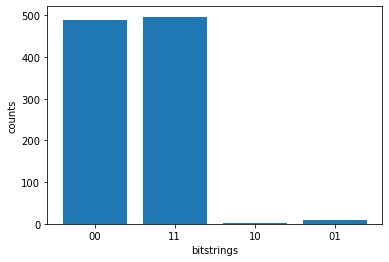

In [6]:
# get measurement shots
counts = result.measurement_counts

# plot using Counter
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

## Additional task information

Apart from the information obtained from the result object, you can get additional information from the task object.

In [7]:
# get id and status of the submitted task
task_id = task.id
status = task.state()
# print('ID of task:', task_id)
print('Status of task:', status)

Status of task: COMPLETED


With the task ID, you can retrieve the result of a complete task.

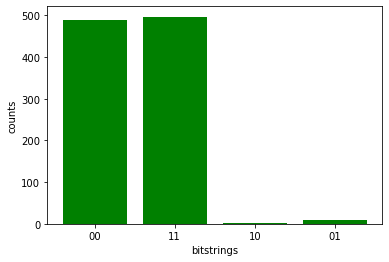

In [8]:
# restore task from unique arn
task_load = AwsQuantumTask(arn=task_id)

# get measurement shots
counts = task_load.result().measurement_counts
# plot using Counter
plt.bar(counts.keys(), counts.values(), color='g');
plt.xlabel('bitstrings');
plt.ylabel('counts');

The metadata of the task is available through `task.metadata()`.

In [10]:
# get the metadata of the submitted task
metadata = task.metadata()

# example for metadata
shots = metadata['shots']
date = metadata['ResponseMetadata']['HTTPHeaders']['date']
print("{} shots taken on {}.".format(shots, date))

s3_bucket = metadata['outputS3Bucket']
s3_sub_directory = metadata['outputS3Directory']
# print('The results are saved in S3 bucket: {}, with the sub-directory: {}'.format(s3_bucket, s3_sub_directory))

1000 shots taken on Fri, 11 Sep 2020 16:20:24 GMT.
